In [1]:
import numpy as np
import os
from PIL import Image
from pathlib import Path 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding



# Please write the optimal hyperparameter values you obtain in the global variable 'optimal_hyperparm' below. This
# variable should contain the values when I look at your submission. I should not have to run your code to populate this
# variable.
optimal_hyperparam = {}

class COC131:
    def __init__(self):
        self.x = None
        self.y = None
        self.scaler = None
        self.best_hyperparams = None

        
    def q1(self, filename=None):
        
        """
        This function should be used to load the data. To speed-up processing in later steps, lower resolution of the
        image to 32*32. The folder names in the root directory of the dataset are the class names. After loading the
        dataset, you should save it into an instance variable self.x (for samples) and self.y (for labels). Both self.x
        and self.y should be numpy arrays of dtype float.
    
        :param filename: this is the name of an actual random image in the dataset. You don't need this to load the
        dataset. This is used for testing the implementation.
        :return res1: a one-dimensional numpy array containing the flattened low-resolution image in file 'filename'.
        Flatten the image in the row major order. The dtype for the array should be float.
        :return res2: a string containing the class name for the image in file 'filename'. This string should be the same as
        one of the folder names in the originally shared dataset.
        """
    
        # Get all subfolders within the dataset directory
        subfolders = [entry.path for entry in os.scandir("../dataset") if entry.is_dir()]
    
        # Creates a list of all paths for the images stored within the ../dataset directory
        image_paths = [os.path.join(subfolder, file)
                     for subfolder in subfolders
                     for file in os.listdir(subfolder) if file.endswith(('.jpg'))] # If the file is an image
    
        # Processes each image within the dataset directory and stores it into the images array
        self.x = np.array([np.array(Image.open(image_path).resize((32, 32)), dtype=float).flatten() for image_path in image_paths])
    
        # Gets the name of the folder that the image is stored in (the classification of the image)
        self.y = np.array([os.path.basename(os.path.dirname(image_path)) for image_path in image_paths])
    
        # If a filename is provided, find and return it
        if filename:
            matching_image_path = next((image_path for image_path in image_paths if filename in image_path), None)
            
            if matching_image_path:
                res1 = np.array(Image.open(matching_image_path).resize((32, 32)), dtype=float).flatten()
                res2 = os.path.basename(os.path.dirname(matching_image_path))  # Extract class name
                return res1, res2
                
        return self.x, self.y
    
    def q2(self, inp):
        """
        This function should compute the standardized data from a given 'inp' data. The function should work for a
        dataset with any number of features.

        :param inp: an array from which the standardized data is to be computed.
        :return res2: a numpy array containing the standardized data with standard deviation of 2.5. The array should
        have the same dimensions as the original data
        :return res1: sklearn object used for standardization.
        """

        standard_scaler = StandardScaler() # Creates a sklearn object used for standardisation
        standardised_data = standard_scaler.fit_transform(inp) # Standardises the data (setting the standard deviation to 1)

        res1 = standard_scaler
        res2 = standardised_data * 2.5 # Standardises the data to have a standard deviation of 2.5

        return res2, res1
        
    
    @staticmethod
    def visualise_standardisation_means_stds(unscaled_data, scaled_data):
        # Compare feature-wise means and standard deviations before and after standardisation
        
        feature_ids = np.arange(unscaled_data.shape[1])
        means_unscaled = np.mean(unscaled_data, axis=0)
        means_scaled = np.mean(scaled_data, axis=0)
        standard_deviations_unscaled = np.std(unscaled_data, axis=0)
        standard_deviations_scaled = np.std(scaled_data, axis=0)

        mean_ylim = (min(means_unscaled.min(), means_scaled.min()),
                     max(means_unscaled.max(), means_scaled.max()))
        
        standard_deviation_ylim = (min(standard_deviations_unscaled.min(), standard_deviations_scaled.min()),
                                   max(standard_deviations_unscaled.max(), standard_deviations_scaled.max()))

        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        
        axs[0].scatter(feature_ids, means_unscaled, label="Original", alpha=0.6)
        axs[0].scatter(feature_ids, means_scaled, label="Standardised", alpha=0.6)
        axs[0].set_title("Feature-wise Means Before and After Standardisation")
        axs[0].set_xlabel("Feature Index")
        axs[0].set_ylabel("Mean Value")
        axs[0].legend()
        axs[0].set_ylim(mean_ylim)

        axs[1].scatter(feature_ids, standard_deviations_unscaled, label="Original", alpha=0.6)
        axs[1].scatter(feature_ids, standard_deviations_scaled, label="Standardised", alpha=0.6)
        axs[1].set_title("Feature-wise Standard Deviations Before and After Standardisation")
        axs[1].set_xlabel("Feature Index")
        axs[1].set_ylabel("Standard Deviation")
        axs[1].legend()
        axs[1].set_ylim(standard_deviation_ylim)

        plt.tight_layout()
        plt.show()

        
    @staticmethod
    def visualise_hyperparam_results(param_labels, cv_scores):
        """
        Generates a horizontal bar chart to visualise cross-validation accuracy 
        for each hyperparameter combination.
        """
        plt.figure(figsize=(12, 6))
        plt.barh(param_labels, cv_scores, color='skyblue')
        plt.xlabel("Mean Cross-Validation Accuracy")
        plt.title("Hyperparameter Optimisation Results")
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    def q3(self, test_size=None, pre_split_data=None, hyperparam=None):
        
        """
        This function should build a MLP Classifier using the dataset loaded in function 'q1' and evaluate model
        performance. You can assume that the function 'q1' has been called prior to calling this function. This function
        should support hyperparameter optimizations.

        :param test_size: the proportion of the dataset that should be reserved for testing. This should be a fraction
        between 0 and 1.
        :param pre_split_data: Can be used to provide data already split into training and testing.
        :param hyperparam: hyperparameter values to be tested during hyperparameter optimization.
        :return: The function should return 1 model object and 3 numpy arrays which contain the loss, training accuracy
        and testing accuracy after each training iteration for the best model you found.
        """
        if self.scaler is None: # If the data to be used within the classifier is not yet standardised, standardise the data.
            self.x, self.scaler = self.q2(self.x)
    
        if test_size is None: # If there is no proportion of data input to be split between training and testing, use 0.3 as the default.
            test_size = 0.3
    
        if pre_split_data: # If pre split data is provided,
            x_train, x_test, y_train, y_test = pre_split_data # x variables are used to contain the image data. y variables are used to contain the labels that each image corresponds to.
        else: # if no data is provided, split the data 
            x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=test_size, random_state=1)
    
        if hyperparam: # If hyperparemeters are provided
            model = MLPClassifier(**hyperparam, random_state=1, max_iter=1000) # Create a MLPClassifier model using random state of 1 (arbitrary value used to keep the same train-test split each run)
            model.fit(x_train, y_train) # Trains the model using input data 
            self.best_hyperparams = hyperparam 
        else: # If no hyperparemeters are provided 
            parameter_grid = { # A grid of values that are tested to find which of those provided is most able to fit on the data provided
                "hidden_layer_sizes": [(50,), (100,), (100, 50), (200,)],
                "learning_rate": ["constant", "adaptive"],
                "solver": ["adam", "sgd"],
                "max_iter": [1000]  # Sets the maximum number of iterations to 1000
            }
    
            grid_search = GridSearchCV( # Performs a grid search (a hyperparameter technique that is used to systemetically find the best combination of parameters for a model)
                MLPClassifier(random_state=1),
                parameter_grid, # Uses the parameters provided, working to find the best available
                cv=3 # Sets the cross-validation model within the grid search to be 3-fold cross validation
            )
            grid_search.fit(x_train, y_train) # Performs a grid search to fit with the training data (images and labels)
    
            # Used to generate a graph that shows how each combination of hyperparemeters affects the loss curve, training and test accuracy
            hyperparameter_labels  = [str(parameters) for parameters in grid_search.cv_results_["params"]] # Get hyperparemeter results from the grid search
            mean_cv_accuracies = grid_search.cv_results_["mean_test_score"] 
            self.visualise_hyperparam_results(hyperparameter_labels, mean_cv_accuracies) # Creates a graph where the hyperparameters correspond to a given CV accuracy
    
            model = grid_search.best_estimator_ # Selects the best model
            self.best_hyperparams = grid_search.best_params_ # Saves the best hyperparameters
    
        training_loss_per_iteration = np.array(model.loss_curve_) if hasattr(model, "loss_curve_") else np.array([]) # Track training loss per epoch if available
        train_accuracy = np.array([accuracy_score(y_train, model.predict(x_train))]) # Captures the final training accuracy after all epochs
        test_accuracy = np.array([accuracy_score(y_test, model.predict(x_test))]) # Captures the final test accuracy after all epochs
    
        return model, training_loss_per_iteration, train_accuracy, test_accuracy
    
    def q4(self):
        """
        This function studies the impact of alpha on the magnitude of model parameters (weights and biases).
        For each value of alpha, a separate MLPClassifier is trained from scratch. Other hyperparameters are
        taken from the best values found in q3().
    
        :return: Dictionary containing alpha values, total weights, and total biases for each model.
        """
        # Split data into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.3, random_state=1)
    
        alpha_values = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 50, 100]
    
        total_weights = []
        total_biases = []
    
        for alpha in alpha_values:
            hyperparams = self.best_hyperparams.copy()
            hyperparams["alpha"] = alpha
    
            model = MLPClassifier(**hyperparams, random_state=1)
            model.fit(x_train, y_train)
    
            # Calculate the sum of absolute weights and biases
            weight_sum = sum(np.sum(np.abs(w)) for w in model.coefs_)
            bias_sum = sum(np.sum(np.abs(b)) for b in model.intercepts_)
    
            total_weights.append(weight_sum)
            total_biases.append(bias_sum)
    
        res = {
            "alpha_values": alpha_values,
            "total_weights": total_weights,
            "total_biases": total_biases
        }
    
        return res

    
    @staticmethod
    def visualise_alpha_vs_params(res):
        """
        Visualizes how alpha affects the total magnitude of weights and biases in the model.
        
        :param res: Dictionary from q4() containing alpha values, weights, and biases.
        """
        alphas = res["alpha_values"]
        weights = res["total_weights"]
        biases = res["total_biases"]
    
        plt.figure(figsize=(8, 5))
        plt.plot(alphas, weights, marker='o', label='Total Weights')
        plt.plot(alphas, biases, marker='s', label='Total Biases')
        plt.xscale('log')
        plt.xlabel("Alpha")
        plt.ylabel("Parameter Magnitude (L1 Norm)")
        plt.title("Effect of Alpha on Weights and Biases")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


    

    def q5(self):
        """
        This function performs hypothesis testing to study the impact of using CV with and without Stratification
        on the performance of MLPClassifier. Set other model hyperparameters to the best values obtained in the previous
        questions. Use 5-fold cross validation for this question. You can assume that the function 'q1' has been called
        prior to calling this function.
    
        :return: The function returns 4 items - the final testing accuracy for both methods of CV, p-value of the
                 test and a string representing the result of hypothesis testing. The string can have only two possible values:
                 'Splitting method impacted performance' or 'Splitting method had no effect'.
        """
    
        # Use best hyperparameters from q3()
        hyperparams = self.best_hyperparams.copy()
    
        # Define the model
        model = MLPClassifier(**hyperparams, random_state=1)
    
        # Define 5-Fold CV (Without Stratification)
        kf = KFold(shuffle=True, random_state=1)
        cross_value_scores_kf = cross_val_score(model, self.x, self.y, cv=kf, n_jobs=-1)
    
        # Define 5-Fold Stratified CV
        skf = StratifiedKFold(shuffle=True, random_state=1)
        cross_value_scores_skf = cross_val_score(model, self.x, self.y, cv=skf, n_jobs=-1)
    
        # Compute mean testing accuracy
        mean_accuracy_kf = np.mean(cross_value_scores_kf)
        mean_accuracy_skf = np.mean(cross_value_scores_skf)
    
        # Perform paired t-test to compare distributions
        t_stat, p_value = ttest_rel(cross_value_scores_kf, cross_value_scores_skf)
    
        # Determine hypothesis test result
        alpha = 0.05  # Significance level
        if p_value < alpha:
            hypothesis_result = "Splitting method impacted performance"
        else:
            hypothesis_result = "Splitting method had no effect"
    
        return mean_accuracy_kf, mean_accuracy_skf, p_value, hypothesis_result

    
    @staticmethod
    def visualise_cv_comparison(scores_kf, scores_skf):
        # Boxplot comparison between K-Fold and Stratified K-Fold cross-validation
        data = [scores_kf, scores_skf]  # Each list contains 5 scores from 5-fold CV
        method_names = ['K-Fold CV', 'Stratified K-Fold CV']
    
        plt.figure(figsize=(8, 5))
        plt.boxplot(data, labels=method_names, patch_artist=True,
                    boxprops=dict(facecolor='lightblue'),
                    medianprops=dict(color='black'))
        plt.title('Cross-Validation Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()



        
    def q6(self):
        """
        This function performs unsupervised learning using LocallyLinearEmbedding in sklearn to reduce the dataset
        to 2 dimensions. It returns the embedded data and corresponding labels to enable visualisation of class separability.
    
        :return: Dictionary containing 2D embedded data and class labels.
        """
    
        if self.x is None or self.y is None:
            raise ValueError("Dataset not loaded. Please call q1() first.")
    
        # Apply LLE with custom n_neighbors, but default 2D output
        lle = LocallyLinearEmbedding(n_neighbors=10, random_state=1)
        embedded_data = lle.fit_transform(self.x)
    
        res = {
            "embedded_data": embedded_data,
            "labels": self.y
        }
    
        return res

    @staticmethod
    def visualise_lle_separability(embedded_data, labels):
        """
        Plots a 2D scatterplot of the LLE embedded data, coloured by class.
    
        :param embedded_data: 2D numpy array from LLE
        :param labels: Class labels corresponding to each point
        """
        labels = np.array(labels)
        unique_classes = np.unique(labels)
        colours = plt.cm.get_cmap('tab10', len(unique_classes))
    
        plt.figure(figsize=(10, 7))
        for i, cls in enumerate(unique_classes):
            idx = labels == cls
            plt.scatter(embedded_data[idx, 0], embedded_data[idx, 1],
                        label=cls, alpha=0.7, s=30, c=[colours(i)])
    
        plt.title("2D Class Visualisation Using Locally Linear Embedding")
        plt.xlabel("LLE Dimension 1")
        plt.ylabel("LLE Dimension 2")
        plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

In [2]:
model = COC131()
model.q1()  # Load the dataset

(array([[149., 121., 120., ..., 106.,  94., 104.],
        [ 56.,  98.,  84., ..., 173., 127., 112.],
        [ 70.,  92.,  98., ..., 204., 160., 151.],
        ...,
        [ 31.,  55.,  79., ...,  30.,  54.,  82.],
        [ 54.,  71.,  81., ...,  53.,  73.,  82.],
        [102., 100., 109., ...,  96.,  96., 106.]], shape=(27000, 3072)),
 array(['AnnualCrop', 'AnnualCrop', 'AnnualCrop', ..., 'SeaLake',
        'SeaLake', 'SeaLake'], shape=(27000,), dtype='<U20'))

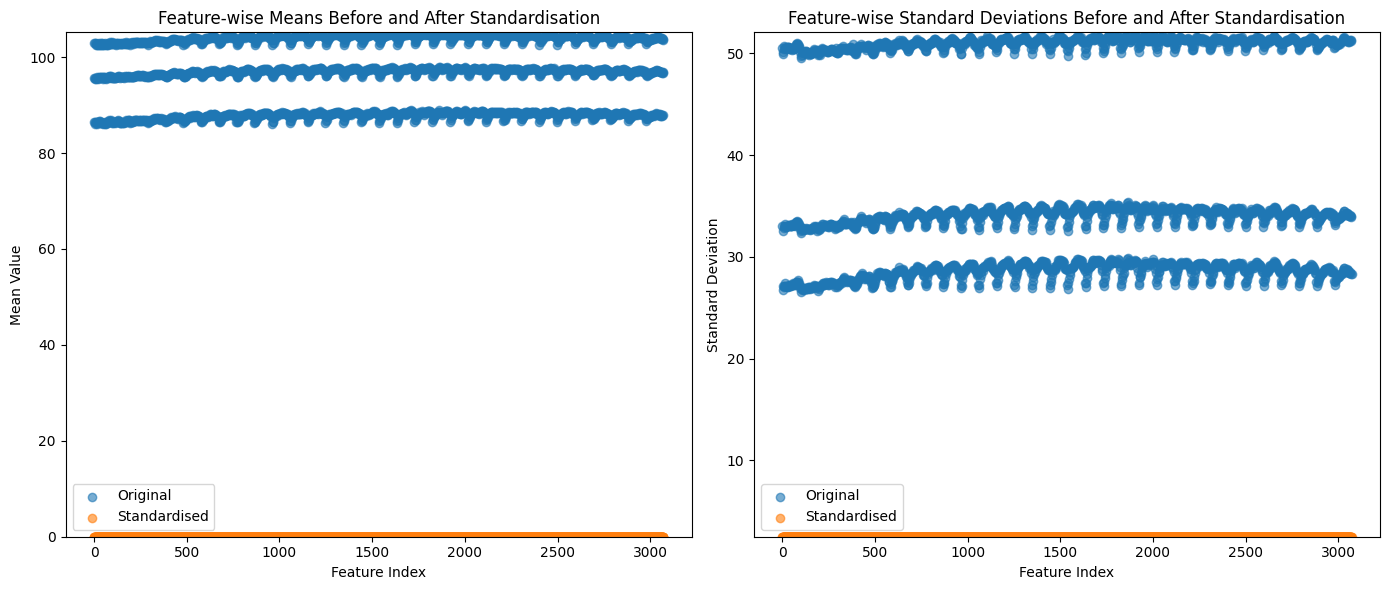

In [3]:
scaled_x, _ = model.q2(model.x)
model.visualise_standardisation_means_stds(model.x, scaled_x)


In [ ]:
model_obj, losses, train_acc, test_acc = model.q3()


In [ ]:
res_q4 = model.q4()
model.visualise_alpha_vs_params(res_q4)  # Use this function I gave in the last message


In [ ]:
kf_acc, skf_acc, p_val, hypothesis_result = model.q5()


In [ ]:
res_q6 = model.q6()
model.visualise_lle_separability(res_q6["embedded_data"], res_q6["labels"])
